In [1]:
import numpy as np

In [2]:
# define a funtion that padds zeros in an Image 
# input : Image,padding size
def f_padds(I,p):
    nRows = I.shape[0]
    nCols = I.shape[1]
    zero_rows = np.zeros((p,nCols))
    O = np.vstack((zero_rows,I))
    O = np.vstack((O,zero_rows))
    zero_cols = np.zeros((nRows+2*p,p))
    O = np.hstack((zero_cols,O))
    O = np.hstack((O,zero_cols))
    return O

In [3]:
# define an Image (5,5) and add padding of size = 1
# hint : use randint to create image

In [4]:
# define a function of conv2D 
# input : Image , p , kerel size
def f_Conv2D(I,k,p):
    kSize = k.shape[0]
    S = f_padds(I,p)
    nRows = S.shape[0]
    nCols = S.shape[1]
    O = np.zeros((I.shape[0],I.shape[1]))
    for i in range(nRows-kSize+1):
        for j in range(nCols-kSize+1):
            P = S[i:i+kSize,j:j+kSize]
            O[i,j] = (P.flatten()*k.flatten()).sum()
    return O

In [5]:
# define activation using ReLU 
# func name is : f_ReLU
def f_ReLU(C):
    C[C<0] = 0
    return C

In [6]:
# define a pooling function which does 2x2 maxpooling
# name is f_pooling
def f_pooling(M):
    nRows = M.shape[0]
    nCols = M.shape[1]
    S = np.zeros((int(nRows/2),int(nCols/2)))
    for i in range(0,nRows-1,2):
        for j in range(0,nCols-1,2):
            S[i//2,j//2] = M[i:i+2,j:j+2].max()
    return S
            

In [7]:
# define the sigmoid function 
# input would be : f (vector),w(vector) and bf
def f_sigmoid(f,w,bf):
    c = f.dot(w) +bf
    y = 1/(1+np.exp(-c))
    return y

This is how you need to write forward pass
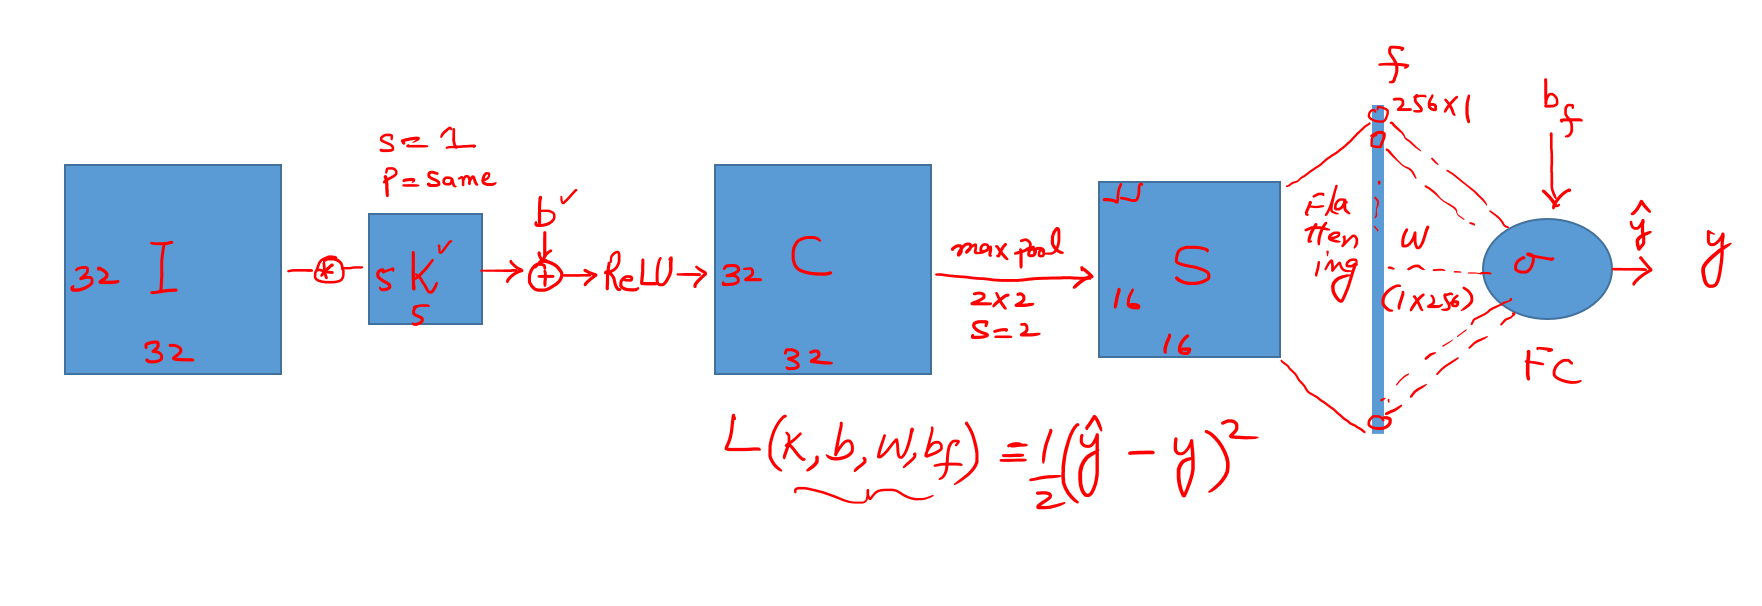

In [8]:
# define a forward pass function (refer the above digram)
def f_forward(I,k,w,bf):
    p = k.shape[0]//2
    C = f_Conv2D(I,k,p) + bf
    C = f_ReLU(C)
    S = f_pooling(C)
    f = S.flatten()
    y_hat = f_sigmoid(f,w,bf)
    return y_hat,C,f

In [9]:
# write function to get the gradient value of loss (L) w.r.t. f
# input would be : y_hat , y , f
def f_diff_f(y_hat,y,f):
    Df = np.squeeze(np.zeros((1,len(f))))
    a = (y_hat-y)*y_hat*(1-y-hat)
    for i in range(len(f)):
        Df[i] = a*f[i]
    return Df

In [10]:
# write function to get the gradient value of loss (L) w.r.t. w(weights)
# input would be : y_hat , y , f
def f_diff_w(y_hat,y,w):
    Dw = np.squeeze(np.zeros((1,len(w))))
    a = (y_hat-y)*y_hat*(1-y_hat)
    for i in range(len(w)):
        Dw[i] = a*w[i]
    return Dw

In [11]:
def getGradient_bf(y_hat,y):
    a = (y_hat-y)*y_hat*(1-y_hat)
    return a

In [12]:
def f_Gradient_S(Df):
    n = int(len(Df)**0.5)
    DS = Df.reshape((n,n))
    return DS

In [13]:
# define the gradient with respect to C
def f_Gradient_C(DS,C):
    r = C.shape[0]
    c = C.shape[1]
    DC = np.zeros((r,c))
    for i in range(0,r,2):
        for j in range(0,c,2):
            C_block = C[i:i+2,j:j+2]
            id = np.unravel_index(np.argmax(C_block),C_block.shape)
            DC[i+id[0],j+id[1]] = DS[i//2,j//2]
    return DC

In [14]:
def f_GetChainRuleGradient(C,DC,I,u,v):
    Dkuv = 0
    for i in range(0,C.shape[0]):
        for j in range (0,C.shape[1]):
            if C[i,j] > 0 and i-u >0 and j-v>0 and i-u <C.shape[0] and j-v < C.shape[1]:
                Dkuv = Dkuv + (I[i-u,j-v]*DC[i,j])
    return Dkuv

In [15]:
# define the function f_gradient_k 
# input would be : C,I,y_hat,y,w
def f_Gradient_k(C,I,y_hat,y,w):
    Df = f_diff_w(y_hat,y,w)
    Ds = f_Gradient_S(Df)
    Dc = f_Gradient_C(Ds,C)
    Dk = np.zeros((5,5))
    for u in range(-2,3):
        for v in range(-2,3):
            Dk[u+2,v+2] = f_GetChainRuleGradient(C,Dc,I,u,v)
    return Dc,Dk

In [16]:
def f_Gradient_b(C,DC):
    Db = DC[C>0].sum()
    return Db

In [17]:
def f_BackwardPass(I,C,w,y_hat,y):
    Dw = f_diff_w(y_hat,y,w)
    Dbf = getGradient_bf(y_hat,y)
    Dc,Dk = f_Gradient_k(C,I,y_hat,y,w)
    Db = f_Gradient_b(C,Dc)
    return Dk,Dw,Dbf,Db

In [18]:
def f_initParams():
    k = 0.01*np.random.randn(5,5)
    b = 0.01*np.random.randn()
    w = np.squeeze(0.01*np.random.randn(1,256))
    bf = 0.01*np.random.randn()
    return k,b,w,bf

In [31]:
I = np.random.randint(1,255,(32,32))
y = 1
k,b,w,bf = f_initParams()
for i in range(5):
    y_hat,C,f = f_forward(I,k,w,bf)
    print(y_hat)
    Dk,Dw,Dbf,Db = f_BackwardPass(I,C,w,y_hat,y)
    alpha = 0.001
    k = k-alpha*Dk
    b = b-alpha*Db
    w = w-alpha*Dw
    bf = bf-alpha*Dbf

0.6827708933246089
0.806536900710069
0.8498899392293721
0.8737619397574916
0.88885816743288


In [46]:
C.shape

(32, 32)

In [47]:
len(f)

256

In [92]:
y_hat

0.5743065475295442

In [89]:
Dk

array([[-0.3205536 ,  0.20848539, -0.08680126, -0.05448099, -0.18791673],
       [ 0.00845169,  0.30438817, -0.69066902, -0.27040205, -0.14579181],
       [-1.59083259, -1.11230033,  0.02961582, -0.1337737 , -0.77644068],
       [-0.50412219,  0.09842326,  0.19003224, -1.02552625, -1.65020242],
       [-0.35782312, -0.30273413,  0.29609808,  0.12514368, -0.92544811]])